In [3]:
# Importando as bibliotecas necessárias
import pandas as pd
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Função para exibir a matriz de confusão
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusão - {title}")
    plt.show()

# Função para exibir a acurácia de cada modelo
def display_accuracy(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Acurácia - {model_name}: {accuracy:.4f}")
    return accuracy

In [5]:
# Carregando as bases de treino e teste
treino = pd.read_csv('train.csv')
teste = pd.read_csv('test.csv')

# Eliminando as colunas com elevada cardinalidade
treino = treino.drop(['Name', 'Ticket', 'Cabin'], axis=1)
teste = teste.drop(['Name', 'Ticket', 'Cabin'], axis=1)

# Tratando valores nulos
treino['Age'].fillna(treino['Age'].mean(), inplace=True)
teste['Age'].fillna(teste['Age'].mean(), inplace=True)
treino['Embarked'].fillna(treino['Embarked'].mode()[0], inplace=True)
teste['Fare'].fillna(teste['Fare'].mean(), inplace=True)

C:\Users\chenr\AppData\Local\Temp\ipykernel_14484\1428008563.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  treino['Age'].fillna(treino['Age'].mean(), inplace=True)
C:\Users\chenr\AppData\Local\Temp\ipykernel_14484\1428008563.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [6]:
# Criando a coluna MaleCheck (1 para masculino, 0 para feminino)
treino['MaleCheck'] = treino['Sex'].apply(lambda x: 1 if x == 'male' else 0)
teste['MaleCheck'] = teste['Sex'].apply(lambda x: 1 if x == 'male' else 0)

# Escalando as colunas 'Age' e 'Fare'
scaler = RobustScaler()
treino[['Age', 'Fare']] = scaler.fit_transform(treino[['Age', 'Fare']])
teste[['Age', 'Fare']] = scaler.transform(teste[['Age', 'Fare']])

# Criando a coluna 'Sozinho' e 'Familiares'
treino['Sozinho'] = treino.apply(lambda x: 1 if (x['SibSp'] == 0 and x['Parch'] == 0) else 0, axis=1)
teste['Sozinho'] = teste.apply(lambda x: 1 if (x['SibSp'] == 0 and x['Parch'] == 0) else 0, axis=1)
treino['Familiares'] = treino['SibSp'] + treino['Parch']
teste['Familiares'] = teste['SibSp'] + teste['Parch']

# Codificando a coluna 'Embarked'
categorias = ['S', 'C', 'Q']
encoder = OrdinalEncoder(categories=[categorias], dtype='int32')
treino['Embarked'] = encoder.fit_transform(treino[['Embarked']])
teste['Embarked'] = encoder.transform(teste[['Embarked']])

# Removendo a coluna 'Sex'
treino = treino.drop('Sex', axis=1)
teste = teste.drop('Sex', axis=1)

In [7]:
# Separando a base de treino em X e y
X = treino.drop(['PassengerId', 'Survived'], axis=1)
y = treino['Survived']

# Dividindo em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)


Treinando o modelo Regressão Logística...
Acurácia - Regressão Logística: 0.8068


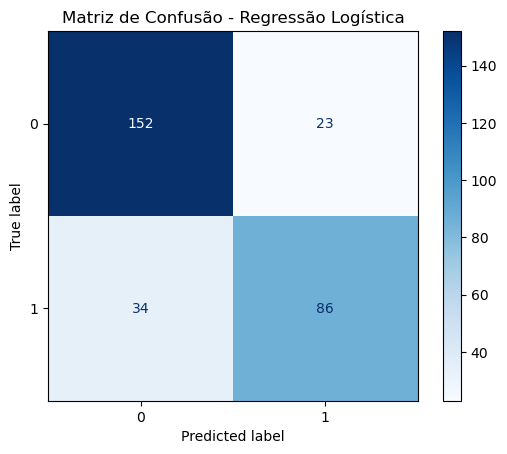


Treinando o modelo Random Forest...
Acurácia - Random Forest: 0.7898


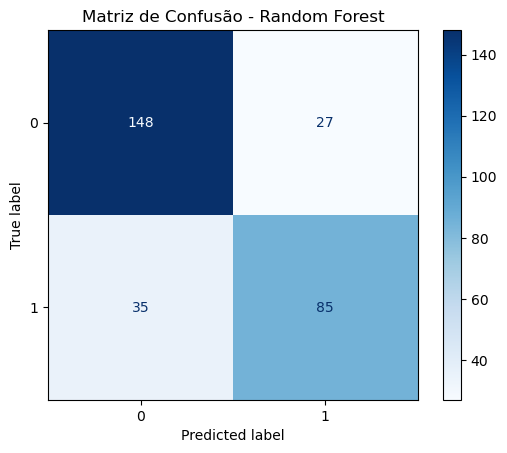


Treinando o modelo MLP Classifier (Redes Neurais)...
Acurácia - MLP Classifier (Redes Neurais): 0.8305


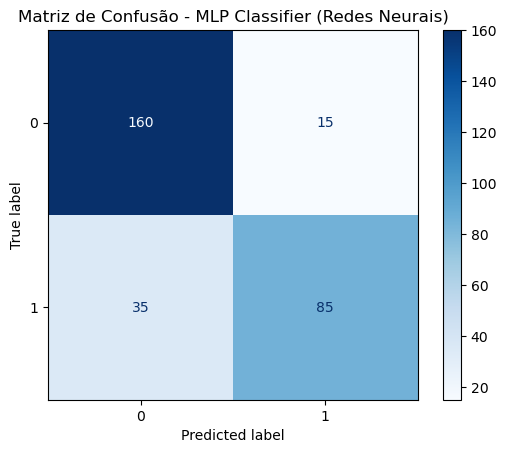

In [8]:
# Modelos de classificação
modelos = {
    'Regressão Logística': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'MLP Classifier (Redes Neurais)': MLPClassifier(random_state=42, max_iter=5000)
}

# Treinando e avaliando os modelos
resultados = {}
for nome, modelo in modelos.items():
    print(f"\nTreinando o modelo {nome}...")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_val)
    resultados[nome] = y_pred
    display_accuracy(y_val, y_pred, nome)
    plot_confusion_matrix(y_val, y_pred, nome)

In [9]:
# Preparando a base de teste
X_teste = teste.drop('PassengerId', axis=1)

# Utilizando o melhor modelo (ajuste conforme necessário)
melhor_modelo = 'MLP Classifier (Redes Neurais)'
y_pred_teste = modelos[melhor_modelo].predict(X_teste)

# Adicionando a previsão na base de teste
teste['Survived'] = y_pred_teste

# Criando a base para envio
base_envio = teste[['PassengerId', 'Survived']]
base_envio.to_csv('resultados_melhorado.csv', index=False)
